In [1]:
import os
# specify the shape of the inputs for our network
image_shape = (28, 28, 1)
# specify the batch size and number of epochs
batch_size = 64
epochs = 70

In [2]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def create_pairs(images, labels):
  imagePairs = []
  labelPairs = []

  numclasses = len(np.unique(labels))
  idx = [np.where(labels ==i)[0] for i in range(numclasses)]

  for ind in range(len(images)):
    currImage = images[ind]
    label = labels[ind]

    indB = np.random.choice(idx[label])
    indImage = images[indB]

    imagePairs.append([currImage, indImage])

    labelPairs.append([1])

    diss_idx = np.where(labels != label)[0]

    diss_image = images[np.random.choice(diss_idx)]

    imagePairs.append([currImage, diss_image])
    labelPairs.append([0])

  return (np.array(imagePairs), np.array(labelPairs))


In [20]:
def euclidean_distance(vecs):
  (imgA, imgB) = vecs
  ss = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
  return K.sqrt(K.maximum(ss, K.epsilon()))

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [16]:
def siamese_model(input_shape, embeddingDim = 48):
  inputs = Input(input_shape)
  x = Conv2D(128, (2, 2), padding = "same", activation = "relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.4)(x)

  x = Conv2D(128, (2, 2), padding = "same", activation = "relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.4)(x)

  pooling = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooling)
  model = Model(inputs, outputs)

  return model

In [7]:
import tensorflow as tf

def contrastiveLoss(y, y_preds, margin=1):
	y = tf.cast(y, y_preds.dtype)
	y_preds_squared = K.square(y_preds)
	margin_squared = K.square(K.maximum(margin - y_preds, 0))
	loss = K.mean(y * y_preds_squared + (1 - y) * margin_squared)
	return loss

In [9]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import fashion_mnist

In [10]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [12]:
x_train = x_train/255.0
x_test = x_test/255.0

x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis=-1)

(training_pairs, training_labels) = create_pairs(x_train, y_train)
(test_pairs, test_labels) = create_pairs(x_test, y_test)

In [21]:
imageA = Input(shape = image_shape)
imageB = Input(shape = image_shape)

model_build = siamese_model(image_shape)
modelA = model_build(imageA)
modelB = model_build(imageB)

distance = Lambda(euclidean_distance)([modelA, modelB])
model = Model(inputs=[imageA, imageB], outputs=distance)

In [23]:
model.compile(loss = contrastiveLoss, optimizer="adam")
history = model.fit(
    [training_pairs[:, 0], training_pairs[:, 1]], training_labels[:],
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels[:]),
    batch_size = batch_size,
    epochs = epochs
)

Epoch 1/70
1875/1875 [==============================] - 24s 7ms/step - loss: 0.1808 - val_loss: 0.1618
Epoch 2/70
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1615 - val_loss: 0.1572
Epoch 3/70
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1588 - val_loss: 0.1551
Epoch 4/70
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1566 - val_loss: 0.1529
Epoch 5/70
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1552 - val_loss: 0.1520
Epoch 6/70
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1542 - val_loss: 0.1504
Epoch 7/70
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1537 - val_loss: 0.1500
Epoch 8/70
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1535 - val_loss: 0.1518
Epoch 9/70
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1527 - val_loss: 0.1501
Epoch 10/70
1875/1875 [==============================] - 14s 7ms/step - l

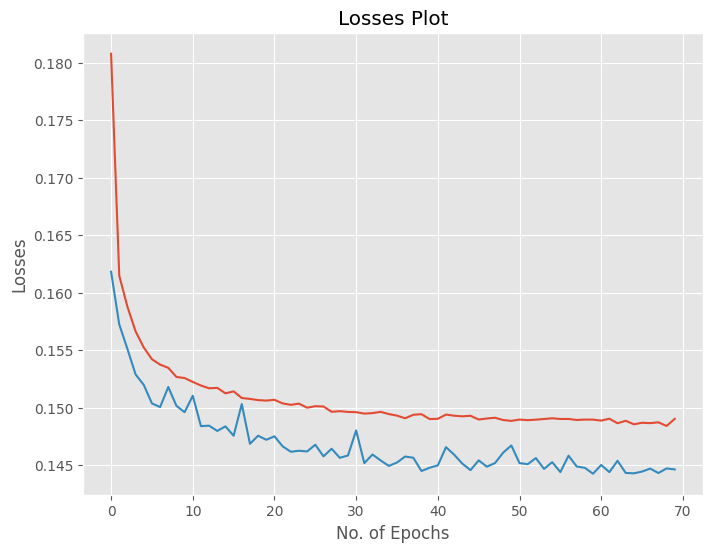

In [24]:
plt.style.use("ggplot")
plt.figure(figsize = (8, 6))
plt.plot(history.history["loss"], label="trainning_loss")
plt.plot(history.history["val_loss"], label="validation_loss")
plt.title("Losses Plot")
plt.xlabel("No. of Epochs")
plt.ylabel("Losses")
plt.show()

In [25]:
import cv2

In [26]:
pairs = np.random.choice(len(test_pairs), size=10)

1/1 [==============================] - 0s 151ms/step


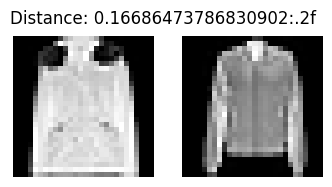

1/1 [==============================] - 0s 32ms/step


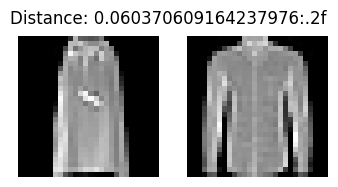

1/1 [==============================] - 0s 34ms/step


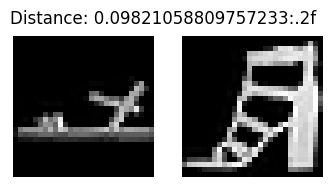

1/1 [==============================] - 0s 32ms/step


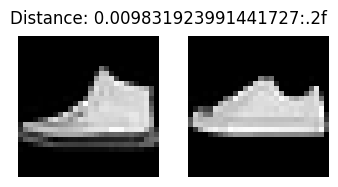

1/1 [==============================] - 0s 31ms/step


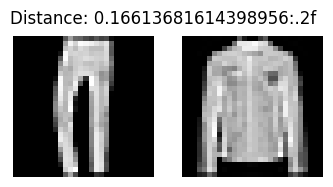

1/1 [==============================] - 0s 30ms/step


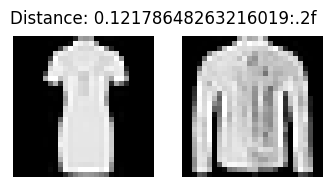

1/1 [==============================] - 0s 37ms/step


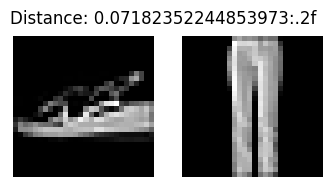

1/1 [==============================] - 0s 32ms/step


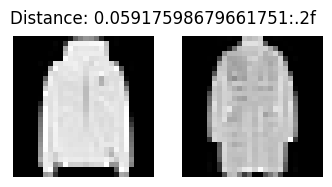

1/1 [==============================] - 0s 28ms/step


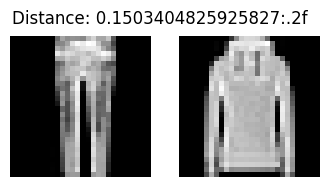

1/1 [==============================] - 0s 30ms/step


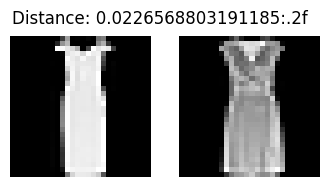

In [27]:
for i in pairs:
  imageA = test_pairs[i][0]
  imageB = test_pairs[i][1]

  baseA = imageA.copy()
  baseB = imageB.copy()
  #print(imageA.shape)

  imageA = np.expand_dims(imageA, axis=-1)
  imageB = np.expand_dims(imageB, axis=-1)
  #print("imageA axis -1")
  #print(imageA.shape)

  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis =0)
  #print("imageA axis 0")
  #print(imageA.shape)

  imageA = imageA/255.0
  imageB = imageB / 255.0

  predicts = model.predict([imageA, imageB])

  proba = predicts[0][0]

  fig = plt.figure("Pair #{}".format(i+1), figsize=(4,2))
  plt.suptitle("Distance: {}:.2f".format(proba))

  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(baseA, cmap=plt.cm.gray)
  plt.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(baseB, cmap=plt.cm.gray)
  plt.axis("off")

  plt.show()